In [29]:
import numpy as np
import sys, os, h5py, re
from trajencoder.flexdmp.flexdmp import FlexDMP
import matplotlib.pyplot as plt
from learning_utils import prepare_data_flexdmp, DMP_reconstruct, calc_loss_flexdmp

In [30]:
import torch as th
from torch.optim import Adam
from network import MLP, setParams
import matplotlib.pyplot as plt
from tqdm import tqdm

device = th.device('cuda' if th.cuda.is_available() else 'cpu')

In [31]:
DMP_ORDER = 30
X, Y, _ = prepare_data_flexdmp("../data/training_D11_N30.hdf5", FlexDMP, DMP_ORDER=DMP_ORDER)
X, Y = th.from_numpy(X).float().to(device), th.from_numpy(Y).float().to(device)

Xv, Yv, Trueth, qd_trueth, qdd_trueth = prepare_data_flexdmp("../data/validating_D4_N30.hdf5", FlexDMP, DMP_ORDER=DMP_ORDER, return_dyddy=True)
Xv, Yv = th.from_numpy(Xv).float().to(device), th.from_numpy(Yv).float().to(device)
X.shape

torch.Size([12100, 4])

In [32]:
net = MLP(4, 61).to(device)
optimizer = Adam(setParams(net, 1e-4), lr = 5e-4)
MSE = th.nn.MSELoss()

In [43]:
n_epochs = 500
batch_size = 256
val = []
train = []

for epoch in tqdm(range(n_epochs)):
    permutation = th.randperm(X.size()[0])
    train_loss = 0.
    vali_loss = 0.
    epo_length = len(list(range(0, X.size()[0], batch_size)))
    for i in range(0, X.size()[0], batch_size):
        optimizer.zero_grad()
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X[indices], Y[indices]
        outputs = net(batch_x)
        loss = MSE(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    with th.no_grad():
        net.eval()
        pred = net(Xv)
        vali_loss = MSE(pred, Yv)
        net.train()
    val.append(vali_loss)
    train.append(train_loss/epo_length)

100%|█████████████████████████████████████████| 500/500 [00:43<00:00, 11.37it/s]


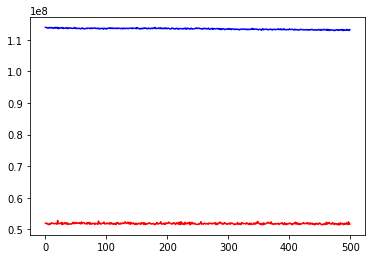

In [44]:
plt.plot(val, '-b')
plt.plot(train, '-r')

In [45]:
pred = pred.detach().cpu().numpy()
Xv_ = Xv.detach().cpu().numpy()
Yv_ = Yv.detach().cpu().numpy()

6NN: 0.005 3.528 under D7 datasets!!

In [46]:
# just for dyna error calc
from casadi_kinodynamics.utils import symbolic_robot
sym_robot = symbolic_robot.symbolic_robot(robot_name='IRB910_2r', tool_mass=0.0,
                                                tool_frame=[0., 0., 0.3, 0., 0., 0.], load_casadi_fnc=False)

In [47]:
error_time, error_target_q, error_dyn_loss, dyna_info = calc_loss_flexdmp(pred, Xv_, Yv_, Trueth, DMP_ORDER, \
                 return_dyn_loss=True, return_dyn_info=True, tau_func=sym_robot.ck.get_inverse_dynamics_rnea(), tau_max=sym_robot.tau_max)
print(error_time, error_target_q, error_dyn_loss)

The rate of dyna violation:  35.41666666666667 %
The peak dyna violation:  [100.10011177   0.        ]
Peak dyna violation occurs at:  [109.   0.]
0.11399999999999993 0.10011093237811249 0.9905618204747415
